In [1]:
import torch
import math

In [2]:
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

In [185]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, noise=None):
        if noise is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.initialize(noise=1e-4)
        else:
            likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
        super().__init__(x, y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        self.covar_module.initialize(lengthscale=0.75)
        
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

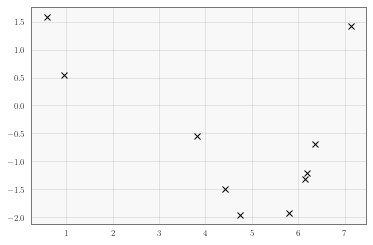

In [289]:
torch.manual_seed(2)
xs = torch.rand(10).mul(10.).sort()[0]
# xs[4] = 5.2
xs[5] = 5.8
train_noise = torch.sin(xs * 1).pow(2.).mul(0.01).add(1e-2)
model = GPModel(xs, torch.randn(xs.size(0)))
model.eval()
with torch.no_grad(), gpytorch.settings.prior_mode():
    ys = model(xs).rsample()
    ys = -ys
plt.plot(xs, ys, 'kx')

In [313]:
model = GPModel(xs.unsqueeze(-1), ys, train_noise)
model.eval()

test_xs = torch.linspace(-5., 15., 1000)
model.eval()
with torch.no_grad():
    preds = model(test_xs)
    lower, upper = preds.confidence_region()
    noise = torch.sin(test_xs * 1).pow(2.).mul(1.).add(1e-2)
    extra = noise.sqrt().mul(2.)
    samples = preds.rsample(sample_shape=torch.Size([10,]))

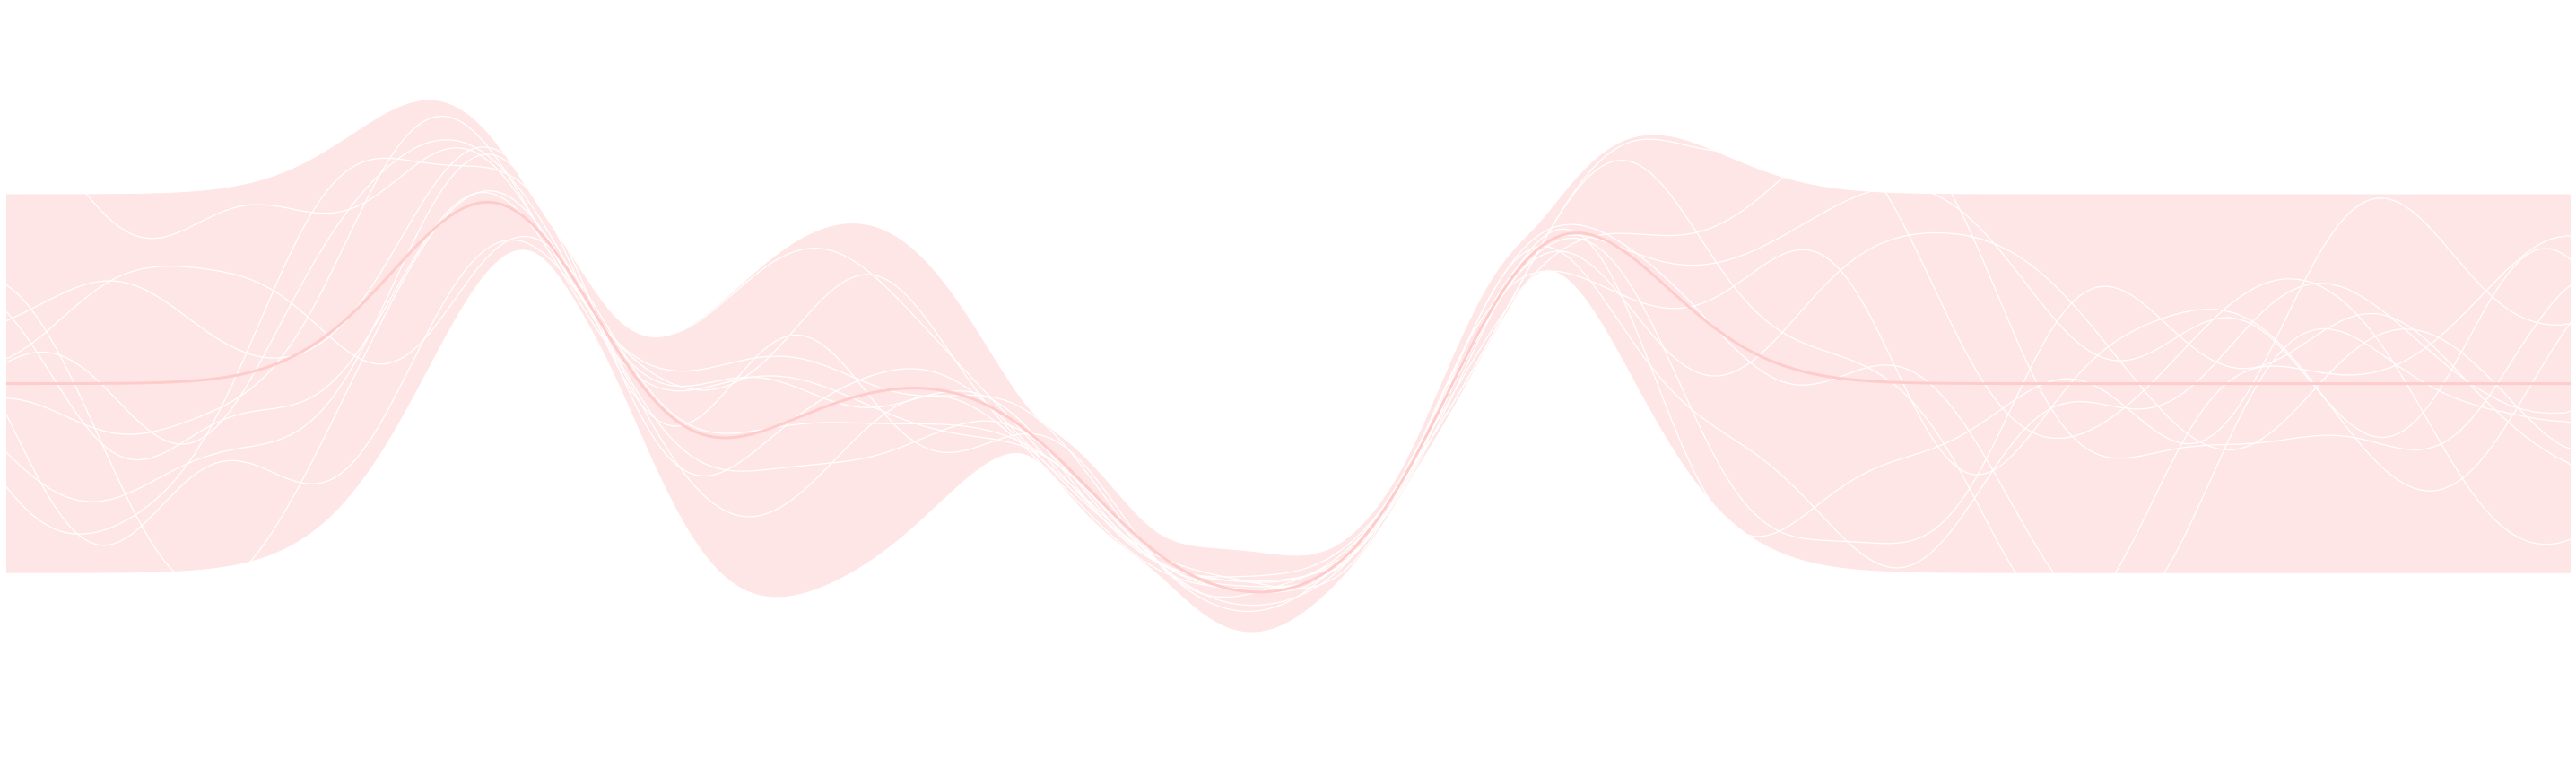

In [318]:
fig, ax = plt.subplots(1, 1, figsize=(40, 12))
ax.fill_between(test_xs.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), color=[1., .9, .9])
ax.plot(test_xs.detach().numpy(), samples.detach().numpy().T, color='w', linewidth=1.25)
ax.plot(test_xs.detach().numpy(), preds.mean.detach().numpy(), color=[1., .8, .8], linewidth=3)
# ax.scatter(xs.detach().numpy(), ys.detach().numpy(), marker='o', color='white',
#            edgecolor=None, s=250, zorder=10, linewidth=5, alpha=1.)

ax.set_ylim([-4, 4])
ax.set_xlim([-3, 14])
# ax.grid(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_facecolor([248. / 256, 249. / 256, 250. / 256])
ax.set_axis_off()
fig.tight_layout()

In [319]:
fig.savefig('logo.svg', transparent=True)